<a href="https://colab.research.google.com/github/YoneDelCastillo/Nonlinear-Maxwells-Eq.-FDTD/blob/main/TFG_2D_lineal_Ley_de_Snell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#MODULOS DE PYTHON

#Librerías:
#Para cálculos y gráficas:
import numpy as np
import matplotlib.pyplot as plt
#Para la animación:
import matplotlib.animation as animation

#FUNCIONES ÚTILES
def cross(A,B):
  return np.array([A[1]*B[2],-A[0]*B[2]])

def gaussian(x,y,x0,y0,a,b):
  return np.exp(-(x-x0)**2/(2*a**2)-(y-y0)**2/(2*b**2))

In [ ]:
#DEFINICION DE VARIABLES Y PARAMETROS

#Número de puntos espaciales
Lx = 2
dx = 0.015
Ly = 1
dy = 0.015

Nx = int(Lx/dx)+2
Ny = int(Ly/dy)+2

#Número de intervalos temporales
T = 2.5
dt = 0.0001

Nt = int(T/dt)


# ε
e = 1
# μ
u = 1

#Definicion de los campos
Ex = np.zeros((Ny,Nx))
Ey = np.zeros((Ny,Nx))
Hz = np.zeros((Ny,Nx))
S  = np.zeros((2,Ny,Nx,Nt))

#Condiciones iniciales a Ex, Ey y Hz
#Posición
X0 = 0.2*Lx
Y0 = 0.5*Ly
#Anchura de la gaussiana
sigma_x = 0.08
sigma_y = 0.2
#Número de onda
Kx = 2*np.pi/(0.10*Lx)

# CONDICIÓN INICIAL

for j in np.arange(1,Ny-1):
   for i in np.arange(1,Nx-1):
     Ey[j,i] = gaussian((i)*dx,(j)*dy,X0     ,Y0,sigma_x,sigma_y)*np.cos(Kx*((i)*dx-X0))
     Hz[j,i] = gaussian((i)*dx,(j)*dy,X0+dx/2,Y0,sigma_x,sigma_y)*np.cos(Kx*((i)*dx-X0+dx/2))

S[:,:,:,0] = cross([Ex,Ey,0],[0,0,Hz])

print(f"Dimensiones del retículo: {Nx}x{Ny}")

Dimensiones del retículo: 135x68


In [ ]:
#GEOMETRÍA DE ε Y μ
#Superficie plana

#Índice de refracción del 2º medio
n_i = 1.75
#Ángulo del plano con respecto al eje x
angs = np.arange(40,90+5,5)
angs = np.radians(angs)
#Ángulos de refracción
angs_d = np.array([])
angs_teor = np.array([])
#Homogéneo por defecto
geo = np.ones((Ny,Nx))
#Distancia al origen
P0 = 0.3*Lx

for ang in angs:
  print(f"Calculando para α = {round(np.degrees(ang),2)}º")

# Se establece la geometría
  for j in np.arange(0,Ny):
    for i in np.arange(0,Nx):
      if j*dy <= np.tan(ang)*(i*dx-P0):
        geo[j,i] = n_i

  e = geo
  u = geo


# CONDICIÓN INICIAL

  for j in np.arange(1,Ny-1):
    for i in np.arange(1,Nx-1):
      Ey[j,i] = gaussian((i)*dx,(j)*dy,X0     ,Y0,sigma_x,sigma_y)*np.cos(Kx*((i)*dx-X0))
      Hz[j,i] = gaussian((i)*dx,(j)*dy,X0+dx/2,Y0,sigma_x,sigma_y)*np.cos(Kx*((i)*dx-X0+dx/2))

  S[:,:,:,0] = cross([Ex,Ey,0],[0,0,Hz])

# ALGORITMO DE YEE

  for n in range(Nt-1):
    print(f"\r{round(n/(Nt-1)*100,2)}%",end="\r")

    # Actualizar los valores en los arrays virtuales
    Hz[1:-1, 1:-1] += (dt/u[1:-1, 1:-1]) * ((Ey[1:-1, 1:-1] - Ey[1:-1, 2:  ]) / dx + (Ex[2:, 1:-1] - Ex[1:-1, 1:-1]) / dy)
    Ey[1:-1, 1:-1] += (dt/e[1:-1, 1:-1]) * ((Hz[1:-1,  :-2] - Hz[1:-1, 1:-1]) / dx)
    Ex[1:-1, 1:-1] += (dt/e[1:-1, 1:-1]) * ((Hz[1:-1, 1:-1] - Hz[ :-2, 1:-1]) / dy)

    # Vector de Poynting
    S[:,:,:,n+1] = cross([Ex,Ey,0],[0,0,Hz])

# Intensidad de la onda
  I = np.sqrt(S[0,:,:,:]**2+S[1,:,:,:]**2)

# CÁLCULO DEL ÁNGULO DE REFRACCIÓN

  t_min = int((P0 - X0 + (0.5*Ly)/np.tan(ang))/T*Nt)+int(0.05*Nt)
  t_max = t_min + int(0.1*Nt)

  arg_max = np.zeros((2,t_max-t_min),dtype="int32")
  Sx_max = np.zeros(t_max-t_min)
  Sy_max = np.zeros(t_max-t_min)

  for m in range(t_min,t_max):
    arg_max[:,m-t_min] = np.unravel_index(I[:,:,m].argmax(), I[:,:,m].shape)
    Sx_max[m-t_min] = S[0,arg_max[0,m-t_min],arg_max[1,m-t_min],m]
    Sy_max[m-t_min] = S[1,arg_max[0,m-t_min],arg_max[1,m-t_min],m]

#Ángulo de refracción respecto a la horizontal
  ang_2 = (-np.arctan(Sy_max/Sx_max)).mean()
#Ángulo de refracción respecto a la normal
  ang_d = 90 - np.degrees(ang_2 + ang)
  angs_d = np.append(angs_d,ang_d)
#Ángulo de refracción teórico
  ang_teor = np.degrees(np.arcsin(1/n_i*np.sin(np.pi/2-ang)))
  angs_teor = np.append(angs_teor,ang_teor)

  print(f"El ángulo de difracción simulado vale: {round(ang_d,2)}º")
  print(f"El ángulo de difracción teórico vale:  {round(ang_teor,2)}º\n")


#se crean 2 array para representar la curva teórica
angs_an = np.radians(np.arange(0,90,0.1))
angs_teor_an = np.arcsin(1/n_i*np.sin(np.pi/2-angs_an))

#GUARDADO DE RESULTADOS
np.save(f"angs_an_n={n_i}.npy",angs_an)
np.save(f"angs_teor_an_n={n_i}.npy",angs_teor_an)
np.save(f"angs_d_n={n_i}.npy",angs_d)
np.save(f"angs_n={n_i}.npy",angs)

Calculando para α = 40.0º
El ángulo de difracción simulado vale: 23.32º
El ángulo de difracción teórico vale:  25.96º

Calculando para α = 45.0º
El ángulo de difracción simulado vale: 22.53º
El ángulo de difracción teórico vale:  23.83º

Calculando para α = 50.0º
El ángulo de difracción simulado vale: 20.35º
El ángulo de difracción teórico vale:  21.55º

Calculando para α = 55.0º
El ángulo de difracción simulado vale: 19.04º
El ángulo de difracción teórico vale:  19.13º

Calculando para α = 60.0º
El ángulo de difracción simulado vale: 16.17º
El ángulo de difracción teórico vale:  16.6º

Calculando para α = 65.0º
El ángulo de difracción simulado vale: 13.69º
El ángulo de difracción teórico vale:  13.97º

Calculando para α = 70.0º
El ángulo de difracción simulado vale: 10.91º
El ángulo de difracción teórico vale:  11.27º

Calculando para α = 75.0º
El ángulo de difracción simulado vale: 8.35º
El ángulo de difracción teórico vale:  8.51º

Calculando para α = 80.0º
El ángulo de difracción s

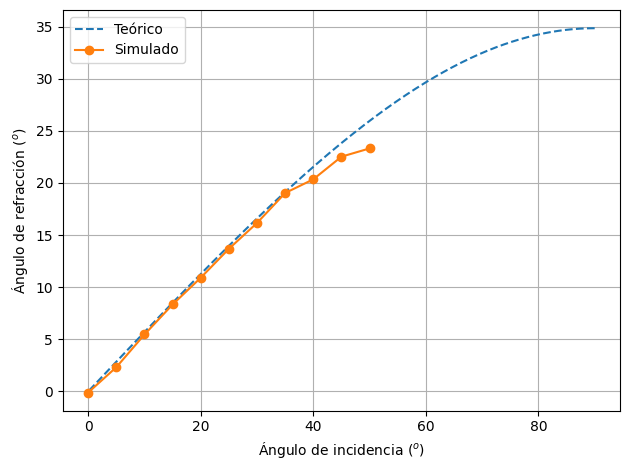

In [ ]:


plt.plot(90-np.degrees(angs_an),np.degrees(angs_teor_an),"--")
plt.plot(90-np.degrees(angs),angs_d,"o-")

plt.grid()
plt.xlabel("Ángulo de incidencia ($^o$)")
plt.ylabel("Ángulo de refracción ($^o$)")
plt.legend(["Teórico","Simulado"])

plt.tight_layout()

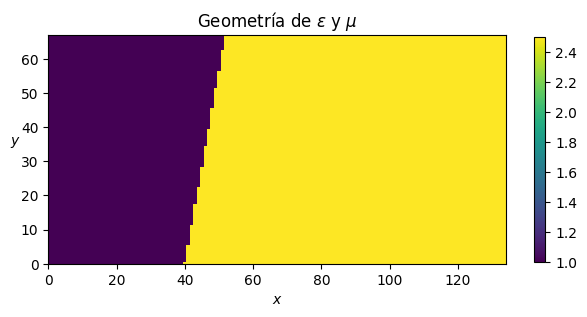

In [ ]:
#GEOMETRÍA DE ε Y μ
#Superficie plana

#Homogéneo por defecto
geo = np.ones((Ny,Nx))
#Índice de refracción del 2º medio
n_i = 2.5

#Ángulo con respecto al eje x
ang = np.radians(80)
#Distancia al origen
P0 = 0.3*Lx

for j in np.arange(0,Ny):
  for i in np.arange(0,Nx):
    if j*dy <= np.tan(ang)*(i*dx-P0):
      geo[j,i] = n_i

#Frontera de la geometría
x = np.arange(0,Nx+0.1,0.1)
y = np.tan(ang)*(x-P0/dx)

e = geo
u = geo


#REPRESENTACIÓN GRÁFICA DE LA GEOMETRÍA

plt.imshow(e,origin="lower")
#plt.plot(x,y,"k-",linewidth=2)

plt.colorbar(shrink=Ly/Lx)
plt.title("Geometría de $\epsilon$ y $\mu$")
plt.xlabel("$x$")
plt.ylabel("$y$",rotation=0)
plt.xlim(0,Nx-1)
plt.ylim(0,Ny-1)

plt.tight_layout()

In [ ]:
# ALGORITMO DE YEE

for n in range(Nt-1):
    print(f"\r{round(n/(Nt-1)*100,2)}%",end="\r")

    # Actualizar los valores en los arrays virtuales
    Hz[1:-1, 1:-1] += (dt/u[1:-1, 1:-1]) * ((Ey[1:-1, 1:-1] - Ey[1:-1, 2:  ]) / dx + (Ex[2:, 1:-1] - Ex[1:-1, 1:-1]) / dy)
    Ey[1:-1, 1:-1] += (dt/e[1:-1, 1:-1]) * ((Hz[1:-1,  :-2] - Hz[1:-1, 1:-1]) / dx)
    Ex[1:-1, 1:-1] += (dt/e[1:-1, 1:-1]) * ((Hz[1:-1, 1:-1] - Hz[ :-2, 1:-1]) / dy)

    # Vector de Poynting
    S[:,:,:,n+1] = cross([Ex,Ey,0],[0,0,Hz])

#Intensidad de la onda
I = np.sqrt(S[0,:,:,:]**2 + S[1,:,:,:]**2)

In [ ]:
#CÁLCULO DEL ÁNGULO DE REFRACCIÓN
t_min = int((P0 - X0 + (0.5*Ly)/np.tan(ang))/T*Nt) + int(0.05*Nt)
t_max = t_min + int(0.1*Nt)

arg_max = np.zeros((2,t_max-t_min),dtype="int32")
Sx_max = np.zeros(t_max-t_min)
Sy_max = np.zeros(t_max-t_min)

for m in range(t_min,t_max):
  arg_max[:,m-t_min] = np.unravel_index(I[:,:,m].argmax(), I[:,:,m].shape)
  Sx_max[m-t_min] = S[0,arg_max[0,m-t_min],arg_max[1,m-t_min],m]
  Sy_max[m-t_min] = S[1,arg_max[0,m-t_min],arg_max[1,m-t_min],m]

#Ángulo de refracción respecto a la horizontal
ang_2 = (-np.arctan(Sy_max/Sx_max)).mean()
#Ángulo de refracción respecto a la normal
ang_d = 90 - np.degrees(ang_2 + ang)
#Ángulo de refracción teórico
ang_teor = np.degrees(np.arcsin(1/n_i*np.sin(np.pi/2-ang)))

print(f"El ángulo de difracción simulado vale: {round(ang_d,2)}º")
print(f"El ángulo de difracción teórico vale:  {round(ang_teor,2)}º")

El ángulo de difracción simulado vale: 0.42º
El ángulo de difracción teórico vale:  3.98º


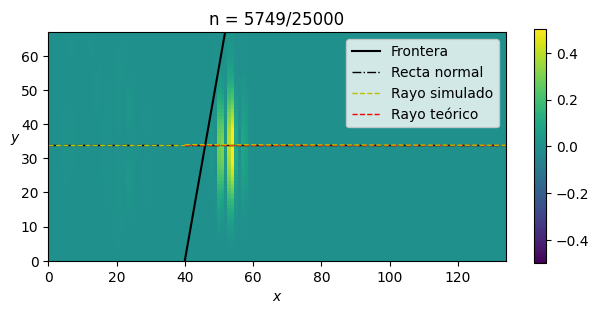

In [ ]:
# GRÁFICA
t = t_max

# Frontera
plt.plot(x,y,"k-",linewidth=1.5)

# Recta normal a la superficie
x_n = np.arange(0,Nx)
y_n = -1/np.tan(ang)*(x_n-(P0/dx + (0.5*Ny)/np.tan(ang))) + 0.5*Ny
plt.plot(x_n,y_n,"k-.",linewidth=1)

# Rayo incidente
plt.axhline(y=Ny/2,color="y",linewidth=1,linestyle="--",xmin=0,xmax=(P0+(0.5*Ly)/np.tan(ang))/Lx)

# Rayo refractado teórico
x_rt = np.arange(int(P0/dx + (0.5*Ny)/np.tan(ang)),Nx)
y_rt = np.tan(ang + np.radians(ang_teor) - np.pi/2)*(x_rt-(P0/dx + (0.5*Ny)/np.tan(ang))) + 0.5*Ny
plt.plot(x_rt,y_rt,"r--",linewidth=1)

# Rayo refractado simulación
x_r = np.arange(int(P0/dx + (0.5*Ny)/np.tan(ang)),Nx)
y_r = np.tan(-ang_2)*(x_r-(P0/dx + (0.5*Ny)/np.tan(ang))) + 0.5*Ny
plt.plot(x_r,y_r,"y--",linewidth=1)

# Componente del campo
plt.imshow(I[:,:,t],vmin=-0.5,vmax=0.5,origin="lower") #,alpha=geo


plt.title(f"n = {t}/{Nt}") #plt.title("Campo Eléctrico")
plt.xlabel("$x$")
plt.ylabel("$y$",rotation=0)
plt.xlim(0,Nx-1)
plt.ylim(0,Ny-1)


plt.colorbar(shrink=0.52)
#plt.clim(0,0.75)

plt.tight_layout()

plt.legend(("Frontera","Recta normal","Rayo simulado","Rayo teórico"),loc="upper right")

plt.savefig(f"n={n_i}_ang={round(np.degrees(ang),0)}_ang_r={round(ang_d,2)}_ang_teor={round(ang_teor,2)}.png",dpi=200)